In [318]:
import numpy as np
import pandas as pd

from glob import glob
from datetime import datetime, timedelta

import seaborn as sns
import matplotlib.pyplot as plt

In [25]:
obdir = '/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/observations/'

#### Use the automated data as a baseline/sanity check
Data is obtained from mesowest API - May use the timeseries or precipitation service<br>
https://developers.synopticdata.com/mesonet/v2/stations/timeseries/<br>
https://developers.synopticdata.com/mesonet/v2/stations/precipitation/<br>
To save long records, will need to access as csv format not json


In [281]:
site_auto = 'CLN_AUTO'
f_auto = glob(obdir + '%s*.csv'%site_auto)[0]

# Remove the units row (SI - C, mm)
data_auto = pd.read_csv(f_auto, low_memory=False)[1:]
data_auto = data_auto.drop(columns='Station_ID')

renames_auto = {'Date_Time':'time', 
                'precip_accum_one_hour_set_1':'swe_auto_mm',
                'snow_interval_set_1':'snow_auto_mm', 
                'snow_depth_set_1':'depth_auto_mm', 
                'air_temp_set_1':'tsfc_c'}

data_auto = data_auto.rename(columns=renames_auto)

# Fix the datatypes
data_auto['time'] = data_auto['time'].astype('datetime64[ns]')
data_auto = data_auto.set_index('time')

data_auto = data_auto.astype({k:np.float32 for k in data_auto.keys()})

data_auto[:10]

,tsfc_c,snow_auto_mm,depth_auto_mm,swe_auto_mm
time,,,,
1997-01-01 00:00:00,1.11,NaN,2311.399902,NaN
1997-01-01 01:00:00,0.56,NaN,2311.399902,NaN
1997-01-01 02:00:00,0.56,NaN,2311.399902,NaN
1997-01-01 03:00:00,2.22,NaN,2311.399902,NaN
1997-01-01 04:00:00,3.33,NaN,2311.399902,NaN
1997-01-01 05:00:00,3.89,NaN,2311.399902,NaN
1997-01-01 06:00:00,3.89,NaN,2311.399902,NaN
1997-01-01 07:00:00,2.78,NaN,2286.000000,NaN
1997-01-01 08:00:00,2.22,NaN,2286.000000,NaN


#### Isolate precipitating (snow) periods

In [285]:
# Since the ERA 3h may be used, reduce hourly to 3h data
kwargs = {'rule':'3H', 'base':0, 
          'label':'right', 'closed':'right'}

data_auto3h = pd.DataFrame([
    data_auto['tsfc_c'].resample(**kwargs).max(),
    data_auto['swe_auto_mm'].resample(**kwargs).sum(),
    data_auto['snow_auto_mm'].resample(**kwargs).sum()]).T

data_auto3h[:10]

,tsfc_c,swe_auto_mm,snow_auto_mm
time,,,
1997-01-01 00:00:00,1.11,0.0,0.0
1997-01-01 03:00:00,2.22,0.0,0.0
1997-01-01 06:00:00,3.89,0.0,0.0
1997-01-01 09:00:00,2.78,0.0,0.0
1997-01-01 12:00:00,2.22,0.0,0.0
1997-01-01 15:00:00,1.67,0.0,0.0
1997-01-01 18:00:00,2.78,0.0,0.0
1997-01-01 21:00:00,4.44,0.0,0.0
1997-01-02 00:00:00,5.56,0.0,0.0


In [289]:
# Write these out to a file later
precip_periods = data_auto[(
    (data_auto['snow_auto_mm'] > 0.) & 
    (data_auto['swe_auto_mm'] > 0.) &
    (data_auto['tsfc_c'] <= 6.))].index

precip_periods3h = data_auto3h[(
    (data_auto3h['snow_auto_mm'] > 0.) & 
    (data_auto3h['swe_auto_mm'] > 0.) &
    (data_auto3h['tsfc_c'] <= 6.))].index

precip_periods[:5], precip_periods3h[:5]

(DatetimeIndex(['2004-10-24 17:00:00', '2004-10-24 21:00:00',
                '2004-10-24 22:00:00', '2004-10-25 06:00:00',
                '2004-10-25 07:00:00'],
               dtype='datetime64[ns]', name='time', freq=None),
 DatetimeIndex(['2004-10-24 18:00:00', '2004-10-24 21:00:00',
                '2004-10-25 00:00:00', '2004-10-25 06:00:00',
                '2004-10-25 09:00:00'],
               dtype='datetime64[ns]', name='time', freq=None))

In [239]:
site = 'CLN'
f = glob(obdir + '%s*.csv'%site)[0]

data_raw = pd.read_csv(f, low_memory=False)
data_raw = data_raw.set_index(['DATE'])

data_time = np.array([[datetime.strptime(d+t, '%m/%d/%y %H%M') for t in [' 0400', ' 1600']] for d in data_raw.index]).flatten()
data_raw = np.array([[(data_raw.loc[d]['%sWATER'%t], data_raw.loc[d]['%sSNOW'%t]) for t in ['0400', '1600']] for d in data_raw.index])
data_raw = data_raw.reshape(-1, 2)

data = pd.DataFrame([data_time, data_raw[:, 0], data_raw[:, 1]]).T
data = data.rename(columns={0:'time', 1:'swe_in', 2:'snow_in'}).set_index('time')

# Convert in to mm
data['swe_mm'] = data['swe_in'] * 25.4
data['snow_mm'] = data['snow_in'] * 25.4
data = data.drop(columns=['swe_in', 'snow_in'])

data[:10]

,swe_mm,snow_mm
time,,
1999-11-01 04:00:00,0,0
1999-11-01 16:00:00,0,0
1999-11-02 04:00:00,0,0
1999-11-02 16:00:00,0,0
1999-11-03 04:00:00,0,0
1999-11-03 16:00:00,0,0
1999-11-04 04:00:00,0,0
1999-11-04 16:00:00,0,0
1999-11-05 04:00:00,0,0


#### Resample the hourlies to match the 12h

In [235]:
data_auto_swe12 = data_auto['swe_auto_mm'].resample('12H', closed='right', label='right', base=4).sum()
data_auto_snow12 = data_auto['snow_auto_mm'].resample('12H', closed='right', label='right', base=4).sum()
data_auto_12 = pd.DataFrame([data_auto_swe12, data_auto_snow12]).T
data_auto_12[:10]

,swe_auto_mm,snow_auto_mm
time,,
1997-01-01 04:00:00,0.0,0.0
1997-01-01 16:00:00,0.0,0.0
1997-01-02 04:00:00,0.0,0.0
1997-01-02 16:00:00,0.0,0.0
1997-01-03 04:00:00,0.0,0.0
1997-01-03 16:00:00,0.0,0.0
1997-01-04 04:00:00,0.0,0.0
1997-01-04 16:00:00,0.0,0.0
1997-01-05 04:00:00,0.0,0.0


In [240]:
data_all = data.merge(data_auto_12, on='time')
data_all[:10]

,swe_mm,snow_mm,swe_auto_mm,snow_auto_mm
time,,,,
1999-11-01 04:00:00,0,0,0.0,0.0
1999-11-01 16:00:00,0,0,0.0,0.0
1999-11-02 04:00:00,0,0,0.0,0.0
1999-11-02 16:00:00,0,0,0.0,0.0
1999-11-03 04:00:00,0,0,0.0,0.0
1999-11-03 16:00:00,0,0,0.0,0.0
1999-11-04 04:00:00,0,0,0.0,0.0
1999-11-04 16:00:00,0,0,0.0,0.0
1999-11-05 04:00:00,0,0,0.0,0.0


#### Ensure that the data isn't mislabeled by plotting/visualizing segments
These should be correct, but check that the beginning of period isn't labeled instead of end, etc.<br>
A time-shift correction can be applied if needed

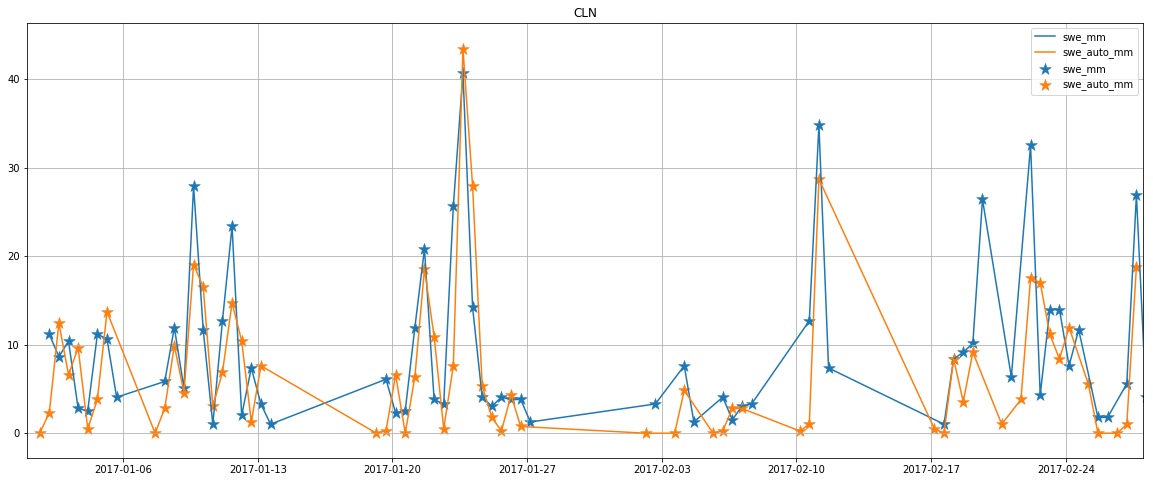

In [342]:
# I think the Alta dataset is labeled with the period START not END... 
# 12 hour time shift seems to fix the issue with the data
time_shift = 12

fig, ax = plt.subplots(1, figsize=(20, 8), facecolor='w')

d0 = datetime(2017, 1, 1, 0, 0)
d1 = datetime(2017, 2, 28, 0, 0)

mask = ((data_all.index > d0) & (data_all.index <= d1) & 
        (data_all['swe_mm'] > 0.) & (data_all['snow_mm'] > 0.))

ax.plot(data_all.loc[mask].index + timedelta(hours=time_shift), data_all.loc[mask, 'swe_mm'], color='C0')
ax.scatter(data_all.loc[mask].index + timedelta(hours=time_shift), data_all.loc[mask, 'swe_mm'], marker='*', s=150, linewidth=0.5, color='C0')

ax.plot(data_all.loc[mask].index, data_all.loc[mask, 'swe_auto_mm'], color='C1')
ax.scatter(data_all.loc[mask].index, data_all.loc[mask, 'swe_auto_mm'], marker='*', s=150, linewidth=0.5, color='C1')

ax.set_xlim([d0, d1])

ax.set_title('%s'%site)

ax.legend()
ax.grid()

plt.show()